# Reconstructing the Drosophila embryo
This tutorial demonstrates how to use `novoSpaRc` to reconstruct single-cell gene expression by using the Drosophila scRNA-seq dataset [Karaiskos et al., 2017, Science]. The two modes of `novoSpaRc` are described: (1) de novo, without any prior information and (2) with using a set of gene expression markers.

In [1]:
import numpy as np
import novosparc as nc
import matplotlib
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist

## Import data
Import the gene names and the gene expression matrix. Although `novoSpaRc` can also operate on raw data, it performs much better when the gene expression matrix is already normalized. Note the format: cells in rows and genes in columns.

In [2]:
dge_path = 'novosparc/datasets/drosophila_scRNAseq/dge_normalized.txt'
gene_names = np.genfromtxt(dge_path, skip_header=True, dtype='str', usecols=range(1))
dge = np.genfromtxt(dge_path, skip_header=True, usecols=range(1, 1298))
dge = dge.T
num_cells = dge.shape[0]

In [3]:
print ( gene_names)
print ('total number of genes in the data:', len(gene_names), '\n')
print (dge)
print ('number of cells and genes in the matrix:', dge.shape)

['128up' '140up' '14-3-3epsilon' ... 'zyd' 'zye' 'Zyx']
total number of genes in the data: 8924 

[[2.57  1.16  8.838 ... 1.16  0.    3.443]
 [2.509 3.007 8.788 ... 1.742 0.    4.305]
 [0.    0.    8.843 ... 0.    0.    4.082]
 ...
 [1.972 2.775 8.333 ... 0.    0.    3.665]
 [0.    0.    8.554 ... 0.    0.    5.354]
 [0.    0.    7.78  ... 0.    0.    3.962]]
number of cells and genes in the matrix: (1297, 8924)


It is advisable to subset the gene expression matrix to the highly variable genes.


In [4]:
hvg_path = 'novosparc/datasets/drosophila_scRNAseq/high_var_genes.txt'
hvg = np.genfromtxt(hvg_path, dtype='str')
dge_hvg = dge[:, np.nonzero(np.in1d(gene_names, hvg))[0]]
num_cells = dge_hvg.shape[0]
print ('number of highly variable genes:', len(hvg))
print ('number of cells and genes in the matrix:', dge_hvg.shape)

number of highly variable genes: 476
number of cells and genes in the matrix: (1297, 476)


### Optional: subsample the gene expression matrix
Subsample the matrix to a smaller number of cells. This helps to first setup the whole reconstruction script quickly and to later assess robustness of the different spatial reconstructions. 

In [5]:
# cells_selected, dge_small = nc.pp.subsample_dge(dge_hvg, 50)
# num_cells = dge_small.shape[0]

## Create the target space
Creating the target space that represents the biological tissue plays an important role, as it influences the geometric component of the reconstruction. In the case where the physical cellular locations are known, such as in the case of the early Drosophila embryo, it is better to use these:

In [6]:
geometry_path = 'novosparc/datasets/bdtnp/geometry.txt'
locations = np.loadtxt(geometry_path, skiprows=1)
# truncate from (x,y,z) to (x,z)
locations = locations[:, [0, 2]]
locations = locations[np.random.choice(locations.shape[0], 3039), :]
num_locations = locations.shape[0]

In [7]:
print ('dimensions of tissue space:', locations.shape, '\n')
print (locations)

dimensions of tissue space: (3039, 2) 

[[ -36.88  -19.74]
 [-116.4    29.56]
 [ 117.77  -26.45]
 ...
 [  29.11   -3.3 ]
 [-110.68   12.87]
 [  71.51   57.44]]


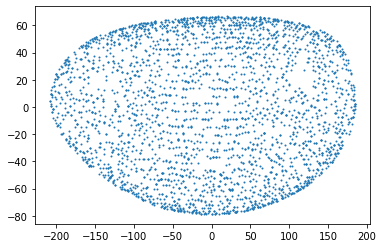

In [8]:
%matplotlib inline
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()

### Alternative tissue spaces
If the cellular locations are not known, the user needs to create. `novoSpaRc` has currently two functions that enable a quick construction of target spaces.
#### Map to a rectangular grid
The function `construct_target_grid` can be used to construct a basic rectangular grid as target space. The only parameter is the total number of cellular locations on the target grid.

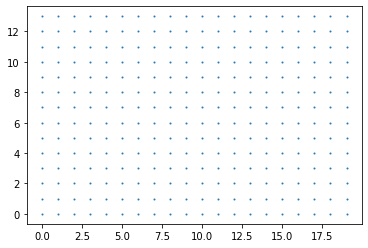

In [9]:
locations = nc.geometry.construct_target_grid(500)
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()

#### Map to a user-generated space
The function `create_target_space_from_image` creates a target space by using a user-generated image. The image has to be a black shape drawn onto a white background, as the one below:

<div>
<img src="https://raw.githubusercontent.com/nukappa/nukappa.github.io/master/images/tissue_example.png", width="250"/>
</div>

In [10]:
tissue_path = 'novosparc/datasets/tissue_example.png'
locations = nc.geometry.create_target_space_from_image(tissue_path)

This will probably create a very large number of locations, so it's better to subsample them.

dimension of original tissue space: (125058, 2)
dimension of downsampled tissue space: (3039, 2)


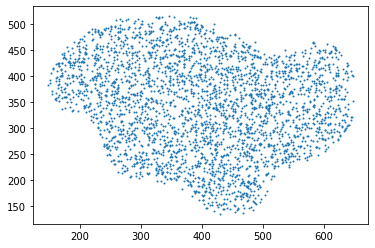

In [11]:
print ('dimension of original tissue space:', locations.shape)
locations = locations[np.random.choice(locations.shape[0], 3039), :]
num_locations = locations.shape[0]
print ('dimension of downsampled tissue space:', locations.shape)
plt.figure()
plt.scatter(locations[:, 0], locations[:, 1], s=1)
plt.show()
plt.close()

## Reconstruct the tissue de novo
We first prepare for the reconstruction by computing the cost matrices. If the tissue space is 1-dimensional (e.g. a line), `num_neighbors` can be reduced to 3.

In [12]:
cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,
                                                                    locations,
                                                                    num_neighbors_source = 5,
                                                                    num_neighbors_target = 5)

Setting up for reconstruction ... done ( 3.86 seconds )


Next choose uniform distributions as starting points for the reconstruction. This implies that the sequenced cells might have originated from each tissue location with equal probability.

In [13]:
p_locations, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)

The `alpha_linear` parameter controls the contribution of the two branches in `novoSpaRc`: `alpha_linear=0` means that no prior information is available, while `alpha_linear=1` implies that the reconstruction will be only based on the reference marker genes provided. Here we aim for a de novo reconstruction.

In [14]:
alpha_linear = 0

Calculate the GW matrix. If numerical errors occur try increasing the epsilon parameter.

In [15]:
gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(1, cost_expression, cost_locations,
                                                        alpha_linear, p_expression, p_locations,
                                                        'square_loss', epsilon=5e-3, verbose=True)

It.  |Err         
-------------------
    0|2.941620e-04|


This is the final object: the sDGE (spatial gene expression matrix) holds expression values for the highly variable genes across all locations.

In [16]:
sdge_hvg = np.dot(dge_hvg.T, gw)

The reconstruction is based on the highly variable genes only, but the spatial expression of the rest can also be recovered

In [17]:
sdge = np.dot(dge.T, gw)
print ('dimensions of the sDGE (genes, locations):', sdge.shape)

dimensions of the sDGE (genes, locations): (8924, 3039)


### Plot spatial gene expression
Plot gene expression patterns in space. In this case the de novo reconstruction is not enough to recover the expression pattern of `ftz` from the data.

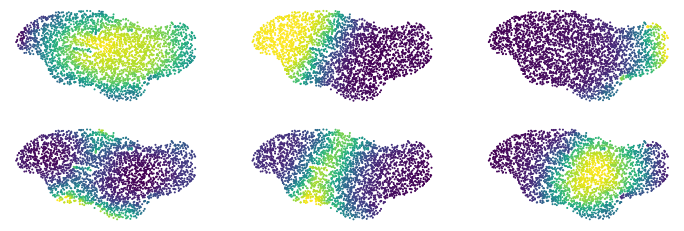

In [18]:
plt.figure(figsize=(12,4))
plt.subplot(231)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'ftz')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(232)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'twi')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(233)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'zen')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(234)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'ImpE2')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(235)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'sim')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(236)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'pyr')[0], :].flatten(), s=1)
plt.axis('off')
plt.show()
plt.close()

## Reconstruct the tissue by using reference marker genes
Available reference marker genes assist `novoSpaRc` and result in general in a much better reconstruction. The setup of the reconstruction is the same as before. Here we only oneed to compute the cost matrix for the reference marker genes. First, import the reference database.

In [19]:
geometry_path = 'novosparc/datasets/bdtnp/geometry.txt'
locations = np.loadtxt(geometry_path, skiprows=1)
# truncate from (x,y,z) to (x,z)
locations = locations[:, [0, 2]]
# use the first 3039 locations from the geometry
locations = locations[:3039, :]
num_locations = locations.shape[0]

cost_expression, cost_locations = nc.rc.setup_for_OT_reconstruction(dge_hvg,
                                                                    locations,
                                                                    num_neighbors_source = 5,
                                                                    num_neighbors_target = 5)
p_locations, p_expression = nc.rc.create_space_distributions(num_locations, num_cells)

# bdtnp.txt is actually named dge.txt - this file only contains 3039 cells
bdtnp_path = 'novosparc/datasets/bdtnp/dge.txt'
insitu_genes = np.genfromtxt(bdtnp_path, usecols=range(84), dtype='str', max_rows=1)
insitu_matrix = np.loadtxt(bdtnp_path, usecols=range(84), skiprows=1)

Setting up for reconstruction ... done ( 3.67 seconds )


Then find the indices of the marker genes in the scRNAseq dataset

In [20]:
markers_in_sc = np.array([], dtype='int')
for marker in insitu_genes:
    marker_index = np.where(gene_names == marker)[0]
    if len(marker_index) > 0:
        markers_in_sc = np.append(markers_in_sc, marker_index[0])

And calculate the matching matrix between the marker genes and the single-cell dataset

In [21]:
cost_marker_genes = cdist(dge[:, markers_in_sc]/np.amax(dge[:, markers_in_sc]),
                          insitu_matrix/np.amax(insitu_matrix))

Choose a different value for `alpha_linear`. Here we choose `0.5`, meaning the geometric and gen marker components are equally weighted for the reconstruction.

In [22]:
alpha_linear = 0.5
gw = nc.rc._GWadjusted.gromov_wasserstein_adjusted_norm(cost_marker_genes, cost_expression, cost_locations,
                                                        alpha_linear, p_expression, p_locations,
                                                        'square_loss', epsilon=5e-3, verbose=True)

It.  |Err         
-------------------
    0|2.800358e-03|


Compute the sDGE and plot spatial gene expression patterns

In [23]:
sdge = np.dot(dge.T, gw)
print ('dimensions of the sDGE (genes, locations):', sdge.shape)

dimensions of the sDGE (genes, locations): (8924, 3039)


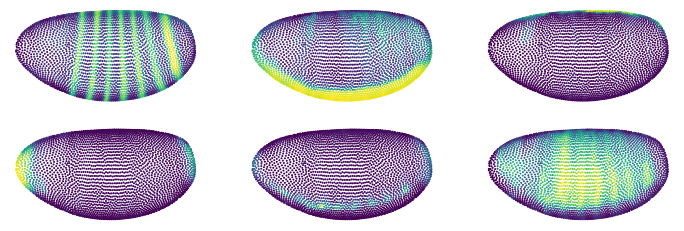

In [24]:
plt.figure(figsize=(12,4))
plt.subplot(231)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'ftz')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(232)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'twi')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(233)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'zen')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(234)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'ImpE2')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(235)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'sim')[0], :].flatten(), s=1)
plt.axis('off')
plt.subplot(236)
plt.scatter(locations[:, 0], locations[:, 1], c=sdge[np.argwhere(gene_names == 'pyr')[0], :].flatten(), s=1)
plt.axis('off')
plt.show()
plt.close()